# analisis de Ventas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

In [4]:
import calendar

In [6]:
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [9]:
df = pd.read_csv("ventas_Historicas.csv")

In [11]:
df.head(10)

,Fecha,Categoría,Cantidad Producto,Ingreso,Precio Unitario,Año
0,2019-01-01,mosaicos,29,603055,6177,2019
1,2019-01-02,griferia de bidet,21,356244,5060,2019
2,2019-01-03,barras de seguridad,19,214035,6762,2019
3,2019-01-04,tinas,11,103686,5301,2019
4,2019-01-05,griferia de ducha y tina,8,593048,5226,2019
5,2019-01-06,ceramicos,6,426540,5192,2019
6,2019-01-07,bidet,24,138456,5769,2019
7,2019-01-08,griferia de bidet,6,569550,5060,2019
8,2019-01-09,wc,5,176555,5152,2019
9,2019-01-10,porcelanato,22,544918,5281,2019


In [61]:
df_monthly = df.resample("M", on="Fecha").sum()

In [25]:
# se corrige la codificacion
df.columns = ['Fecha', 'Categoria', 'Cantidad_Producto', 'Ingreso', 'Precio_Unitario', 'Año']

In [63]:
df_ventas['Fecha'] = pd.to_datetime(df_ventas['Fecha'])  # Convertir a tipo fecha
df_ventas.set_index('Fecha', inplace=True)  # Usar como índice


In [65]:
df['Fecha'] = pd.to_datetime(df['Fecha'])

In [37]:
# agrupa por fecha para analisis de series temporales
df_ventas = df.groupby('Fecha').agg({'Ingreso': 'sum', 'Cantidad_Producto': 'sum'}).reset_index()

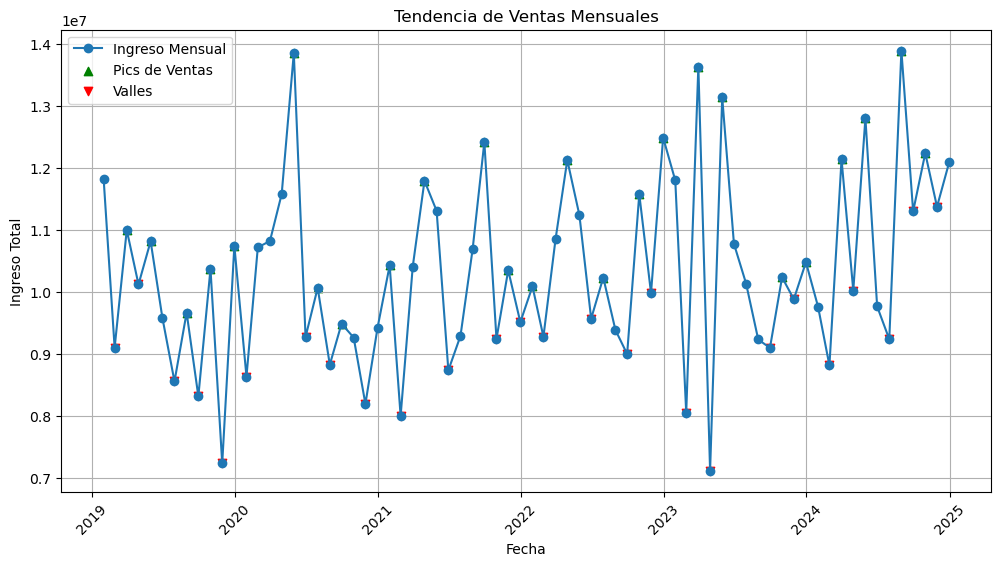

In [39]:
from scipy.signal import find_peaks

# Extraer ingresos mensuales
ventas = df_monthly["Ingreso"]

# Encontrar picos (máximos locales)
picos, _ = find_peaks(ventas, distance=2)  # Ajusta "distance" según los datos

# Encontrar valles (mínimos locales)
valles, _ = find_peaks(-ventas, distance=2)

# Graficar la tendencia de ingresos mensuales
plt.figure(figsize=(12, 6))
plt.plot(df_monthly.index, ventas, marker='o', linestyle='-', label="Ingreso Mensual")
plt.scatter(df_monthly.index[picos], ventas.iloc[picos], color='g', label="Pics de Ventas", marker="^")
plt.scatter(df_monthly.index[valles], ventas.iloc[valles], color='red', label="Valles", marker="v")

plt.title("Tendencia de Ventas Mensuales")
plt.xlabel("Fecha")
plt.ylabel("Ingreso Total")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


C:\Users\Axel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Axel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Axel\AppData\Local\Temp\ipykernel_11888\676731690.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(meses_esp, rotation=45, fontsize=12, color="white")


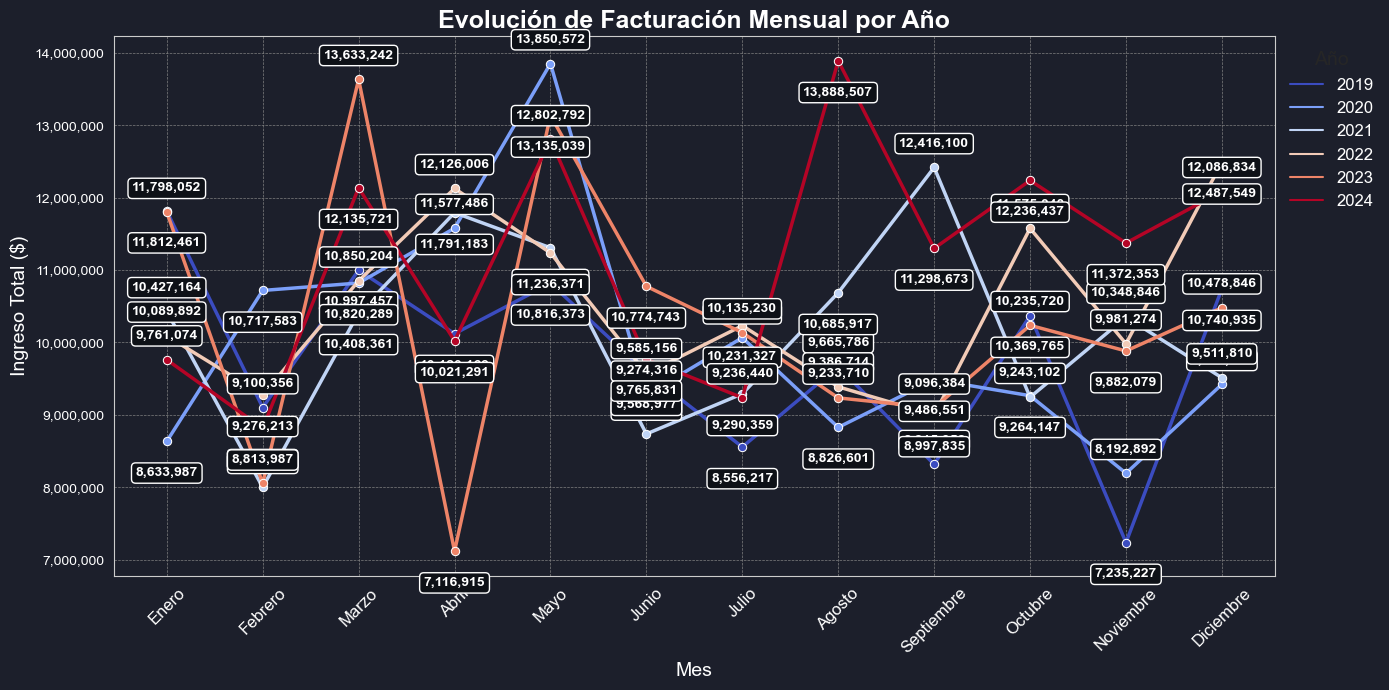

In [41]:
df["Fecha"] = pd.to_datetime(df["Fecha"])

# Extraer año y mes
df["Año"] = df["Fecha"].dt.year
df["Mes"] = df["Fecha"].dt.month

# Agrupar por año y mes
ventas_por_mes = df.groupby(["Año", "Mes"])["Ingreso"].sum().reset_index()

# Convertir Mes a nombre completo en español
meses_esp = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", 
             "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]
ventas_por_mes["Mes"] = ventas_por_mes["Mes"].apply(lambda x: meses_esp[x-1])

# Crear figura con fondo oscuro elegante
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(14, 7))
fig.patch.set_facecolor("#1c1f2b")  # Fondo general
ax.set_facecolor("#1c1f2b")  # Fondo del gráfico

# Graficar con líneas diferenciadas por año
sns.lineplot(data=ventas_por_mes, x="Mes", y="Ingreso", hue="Año", marker="o", linewidth=2.5, palette="coolwarm", ax=ax)

# Añadir etiquetas de valores en los puntos
for _, row in ventas_por_mes.iterrows():
    offset = 15 if row["Ingreso"] % 2 == 0 else -25  # Alternar posición arriba/abajo
    ax.annotate(f"{int(row['Ingreso']):,}", 
                (row["Mes"], row["Ingreso"]), 
                textcoords="offset points", 
                xytext=(0, offset),  
                ha="center", 
                fontsize=10, 
                color="white", 
                fontweight="bold",
                bbox=dict(facecolor="#0e1117", edgecolor="white", boxstyle="round,pad=0.3"))  

# Mejorar la visualización
ax.set_title("Evolución de Facturación Mensual por Año", fontsize=18, fontweight="bold", color="white")
ax.set_xlabel("Mes", fontsize=14, color="white")
ax.set_ylabel("Ingreso Total ($)", fontsize=14, color="white")
ax.set_xticklabels(meses_esp, rotation=45, fontsize=12, color="white")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))  # Formato de miles
ax.tick_params(colors="white")

# Personalizar leyenda
ax.legend(title="Año", title_fontsize=14, fontsize=12, loc="upper left", bbox_to_anchor=(1, 1), frameon=False, labelcolor="white")

# Ajustar cuadrícula para mejor visualización
ax.grid(color="gray", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()

C:\Users\Axel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Axel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


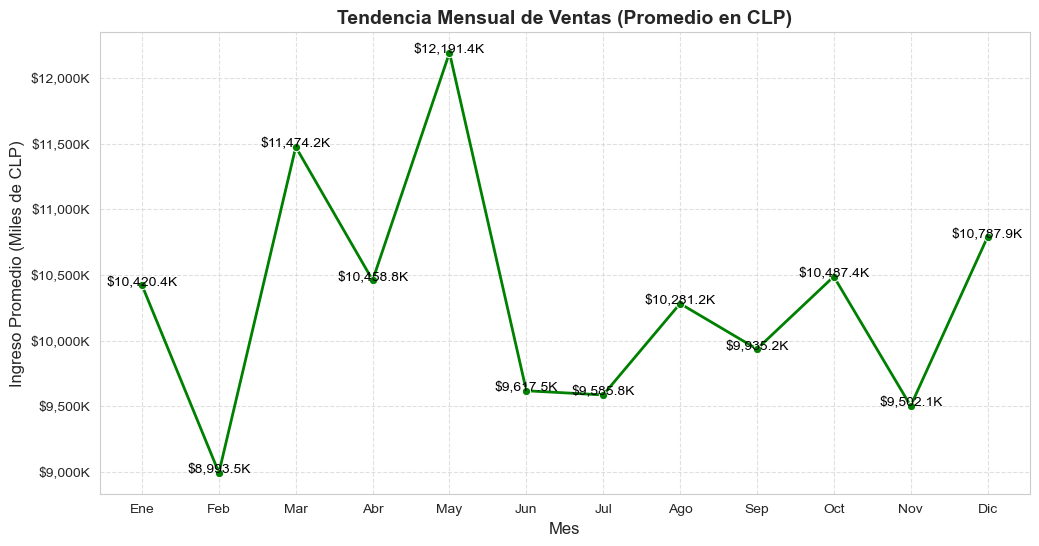

In [45]:
# Agrupar ingresos promedio por mes
ventas_estacionalidad = df.groupby(["Año", "Mes"])["Ingreso"].sum().groupby("Mes").mean()

# Crear gráfico mejorado
plt.figure(figsize=(12, 6))
sns.lineplot(x=ventas_estacionalidad.index, y=ventas_estacionalidad.values, marker="o", color="g", linewidth=2)

# Formatear ejes y etiquetas
plt.title("Tendencia Mensual de Ventas (Promedio en CLP)", fontsize=14, fontweight="bold")
plt.xlabel("Mes", fontsize=12)
plt.ylabel("Ingreso Promedio (Miles de CLP)", fontsize=12)

# Reemplazar números de meses por nombres
meses = ["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"]
plt.xticks(ticks=range(1, 13), labels=meses)

# Formatear valores del eje Y en miles de CLP
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"${x/1000:,.0f}K"))

# Agregar etiquetas de valor en cada punto
for mes, ingreso in zip(ventas_estacionalidad.index, ventas_estacionalidad.values):
    plt.text(mes, ingreso, f"${ingreso/1000:,.1f}K", ha="center", fontsize=10, color="black")

plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

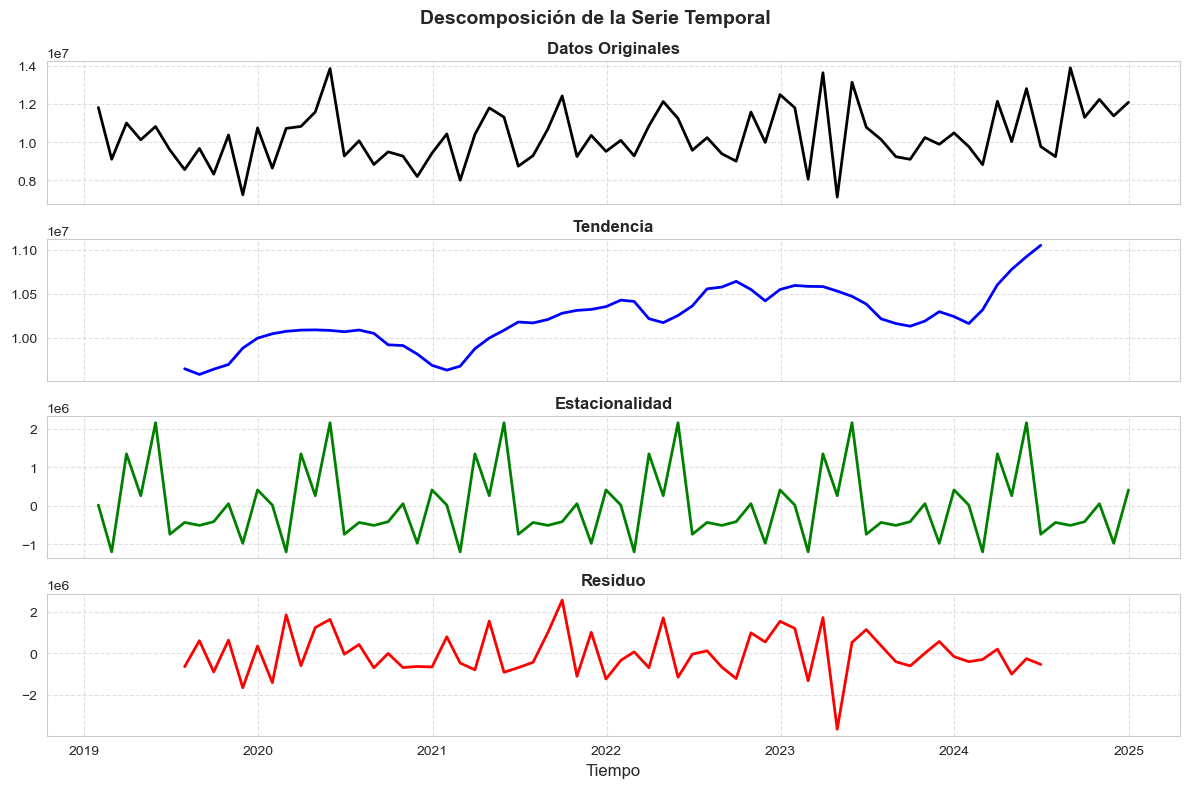

In [46]:
# Descomponer la serie temporal
result = seasonal_decompose(ventas, model="additive", period=12)  # Ajusta el período según los datos

# Crear gráfico mejorado
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

componentes = ["Datos Originales", "Tendencia", "Estacionalidad", "Residuo"]
colores = ["black", "blue", "green", "red"]
series = [result.observed, result.trend, result.seasonal, result.resid]

for ax, serie, nombre, color in zip(axes, series, componentes, colores):
    ax.plot(serie, color=color, linewidth=2)
    ax.set_title(nombre, fontsize=12, fontweight="bold")
    ax.grid(True, linestyle="--", alpha=0.6)

# Ajustes finales
axes[-1].set_xlabel("Tiempo", fontsize=12)
fig.suptitle("Descomposición de la Serie Temporal", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [48]:
df_ventas.info

<bound method DataFrame.info of           Fecha  Ingreso  Cantidad_Producto
0    2019-01-01   603055                 29
1    2019-01-02   356244                 21
2    2019-01-03   214035                 19
3    2019-01-04   103686                 11
4    2019-01-05   593048                  8
...         ...      ...                ...
2187 2024-12-27    37362                  3
2188 2024-12-28   243180                 14
2189 2024-12-29  1028475                  7
2190 2024-12-30   385884                  4
2191 2024-12-31   596240                 29

[2192 rows x 3 columns]>

C:\Users\Axel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Axel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


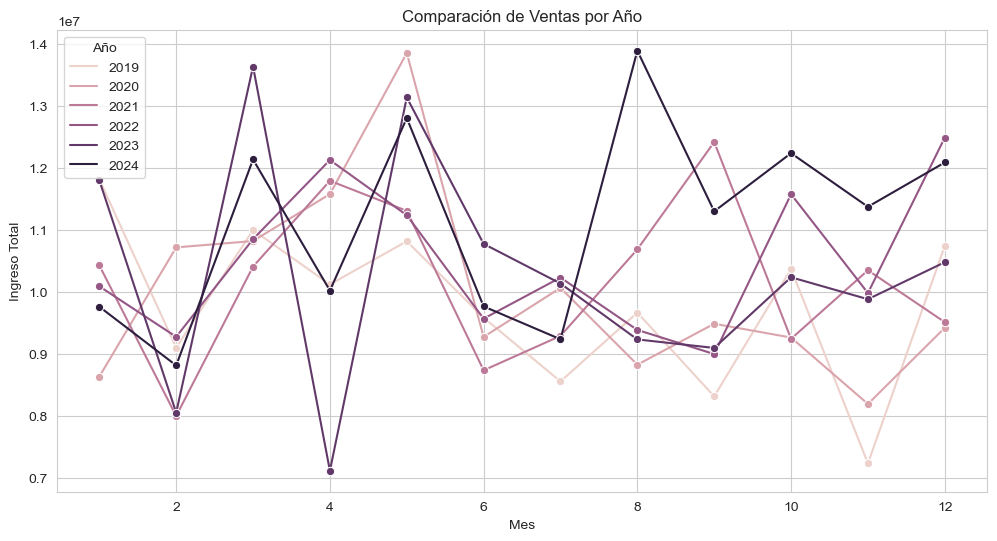

In [49]:
df_monthly["Año"] = df_monthly.index.year
df_monthly["Mes"] = df_monthly.index.month

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_monthly, x="Mes", y="Ingreso", hue="Año", marker="o")
plt.title("Comparación de Ventas por Año")
plt.xlabel("Mes")
plt.ylabel("Ingreso Total")
plt.legend(title="Año")
plt.grid(True)
plt.show()


<Figure size 1200x800 with 0 Axes>

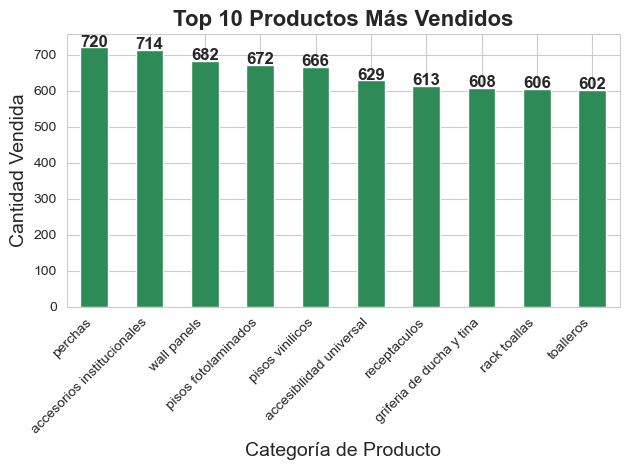

El producto más vendido es: perchas con 720 unidades.


In [50]:
# Agrupar y ordenar los productos
productos_top = df.groupby('Categoria').agg({'Cantidad_Producto': 'sum'}).sort_values(by='Cantidad_Producto', ascending=False)

# Extraer el producto más vendido
producto_mas_vendido = productos_top.idxmax().values[0]
cantidad_max = productos_top.max().values[0]

# Crear el gráfico de barras mejorado
plt.figure(figsize=(12, 8))

# Crear una paleta de colores que resalte el más vendido
color_solid = "#2E8B57"

# Graficar las barras con el color personalizado
ax = productos_top.head(10).plot(kind='bar', color=color_solid, legend=False)

# Títulos y etiquetas
plt.title("Top 10 Productos Más Vendidos", fontsize=16, fontweight='bold')
plt.xlabel("Categoría de Producto", fontsize=14)
plt.ylabel("Cantidad Vendida", fontsize=14)

# Agregar valores sobre las barras
for i, v in enumerate(productos_top.head(10)['Cantidad_Producto']):
    ax.text(i, v + 2, str(v), ha='center', fontsize=12, fontweight='bold')

# Ajustar las etiquetas del eje X
plt.xticks(rotation=45, ha='right')

# Ajustar el espaciado
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Mostrar el producto más vendido
print(f"El producto más vendido es: {producto_mas_vendido} con {cantidad_max} unidades.")

<Figure size 1200x800 with 0 Axes>

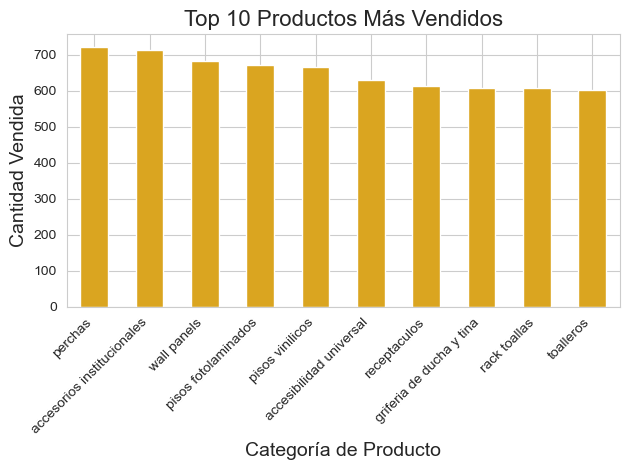

In [51]:
# Gráfico de rentabilidad
# Agrupar y ordenar los productos
productos_top = df.groupby('Categoria').agg({'Cantidad_Producto': 'sum'}).sort_values(by='Cantidad_Producto', ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(12, 8))  # Aumentar el tamaño de la figura
productos_top.head(10).plot(kind='bar', color='goldenrod', legend=False)

# Títulos y etiquetas
plt.title("Top 10 Productos Más Vendidos", fontsize=16)
plt.xlabel("Categoría de Producto", fontsize=14)
plt.ylabel("Cantidad Vendida", fontsize=14)

# Ajustar las etiquetas del eje X
plt.xticks(rotation=45, ha='right')  # Rotar y alinear a la derecha

# Ajustar el espaciado
plt.tight_layout()

# Mostrar el gráfico
plt.show()

C:\Users\Axel\AppData\Local\Temp\ipykernel_11888\1836761078.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(index, value + 10, f'{margen_categoria["Porcentaje_Ganancia"][index]:.2f}%',


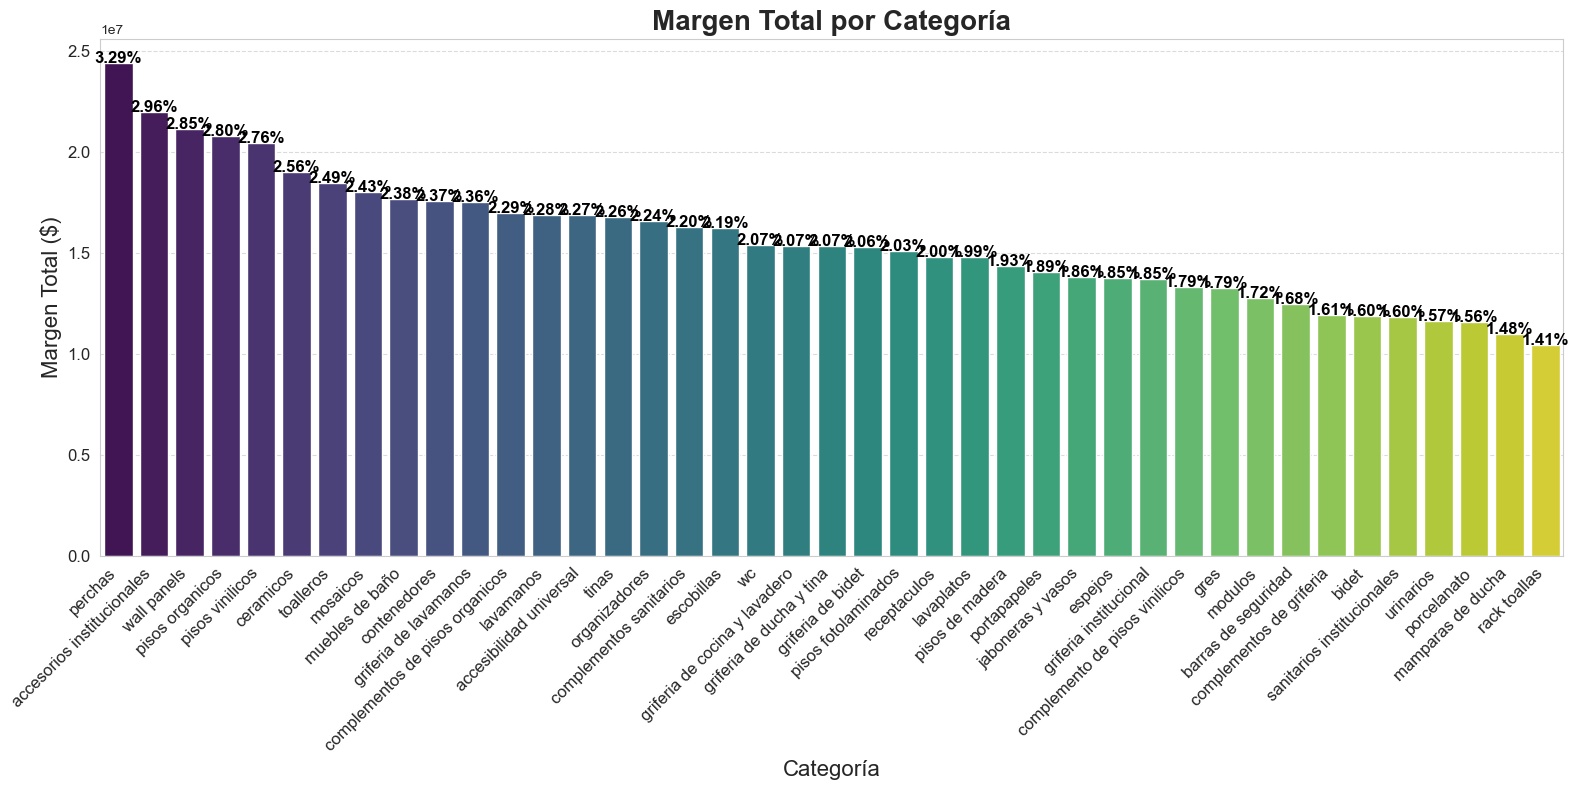

In [52]:
# Cálculo del Costo Estimado y Margen
df['Costo_Estimado'] = df['Precio_Unitario'] * 0.7  # Margen de 30%
df['Margen'] = df['Ingreso'] - (df['Costo_Estimado'] * df['Cantidad_Producto'])

# Agrupar por categoría y calcular el margen total
margen_categoria = df[['Categoria', 'Margen']].groupby('Categoria').sum().sort_values(by='Margen', ascending=False)

# Calcular el porcentaje de ganancia
margen_categoria['Porcentaje_Ganancia'] = (margen_categoria['Margen'] / df['Ingreso'].sum()) * 100

# Crear gráfico de barras
plt.figure(figsize=(16, 8))  # Tamaño de la figura más grande
sns.barplot(x=margen_categoria.index, y=margen_categoria['Margen'], palette='viridis')

# Mejorar la visualización
plt.title("Margen Total por Categoría", fontsize=20, fontweight='bold')
plt.xlabel("Categoría", fontsize=16)
plt.ylabel("Margen Total ($)", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Mejor alineación de las etiquetas
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir las etiquetas de porcentaje sobre las barras
for index, value in enumerate(margen_categoria['Margen']):
    plt.text(index, value + 10, f'{margen_categoria["Porcentaje_Ganancia"][index]:.2f}%', 
             ha='center', fontsize=12, color='black', fontweight='bold')

# Ajustar el espacio
plt.tight_layout()

# Mostrar el gráfico
plt.show()


C:\Users\Axel\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Axel\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Axel\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


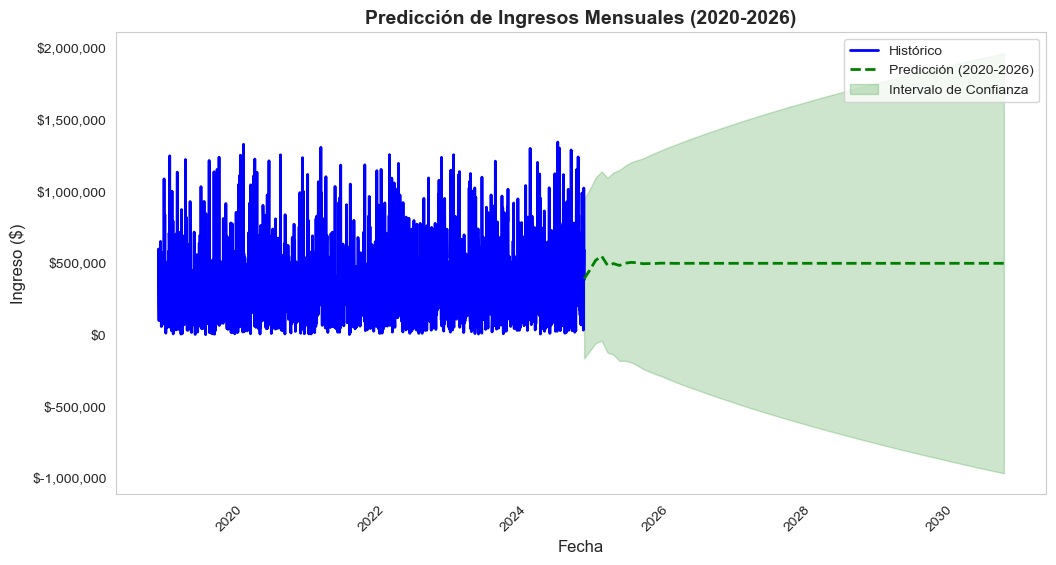

In [67]:

from statsmodels.tsa.arima.model import ARIMA

# Asegurarse de que 'Ingreso' es de tipo numérico
df_ventas['Ingreso'] = pd.to_numeric(df_ventas['Ingreso'], errors='coerce')

# Entrenar el modelo ARIMA
modelo = ARIMA(df_ventas['Ingreso'], order=(5,1,0))
modelo_fit = modelo.fit()

# Hacer predicción para los próximos 6 años (72 meses)
predicciones = modelo_fit.get_forecast(steps=72)
pred_vals = predicciones.predicted_mean  # Valores predichos
conf_int = predicciones.conf_int()  # Intervalo de confianza

# Crear fechas correctas para la predicción en meses
fechas_pred = pd.date_range(start=df_ventas.index[-1], periods=72, freq='M')

# Graficar los ingresos históricos
plt.figure(figsize=(12,6))
plt.plot(df_ventas.index, df_ventas['Ingreso'], label="Histórico", color='blue', linewidth=2)

# Graficar la predicción
plt.plot(fechas_pred, pred_vals, label="Predicción (2020-2026)", color='green', linestyle="dashed", linewidth=2)

# Graficar el intervalo de confianza
plt.fill_between(fechas_pred, conf_int.iloc[:,0], conf_int.iloc[:,1], color='green', alpha=0.2, label="Intervalo de Confianza")

# Mejorar la visualización
plt.title("Predicción de Ingresos Mensuales (2020-2026)", fontsize=14, fontweight="bold")
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Ingreso ($)", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid()

# Añadir formato a los ejes para mostrar el ingreso de manera más legible
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))

# Mostrar gráfico
plt.show()

15:03:30 - cmdstanpy - INFO - Chain [1] start processing
15:03:31 - cmdstanpy - INFO - Chain [1] done processing


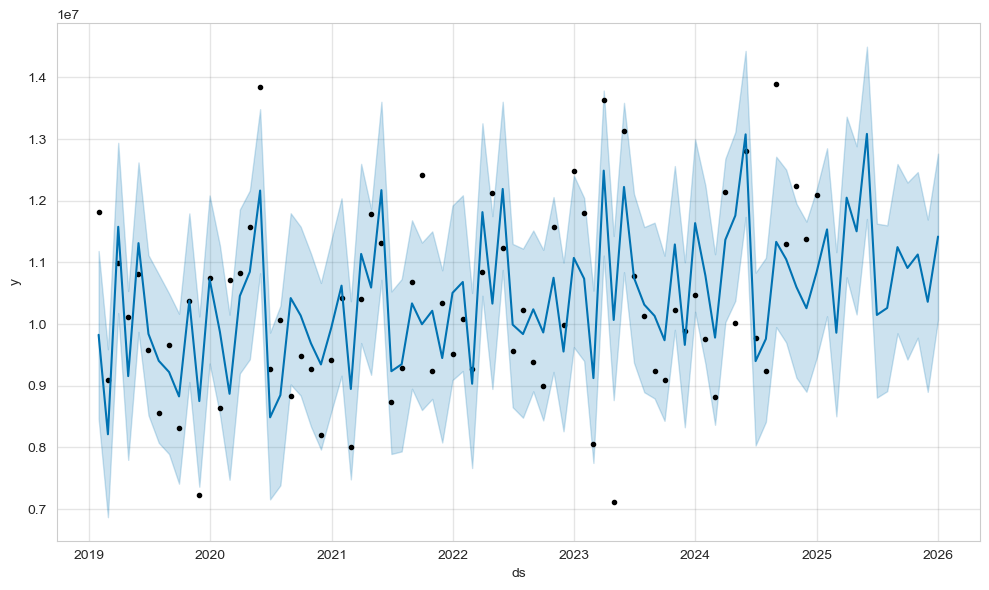

In [95]:
from prophet import Prophet

# Preparar datos para Prophet
df_prophet = df_monthly.reset_index()[["Fecha", "Ingreso"]]
df_prophet.columns = ["ds", "y"]  # Prophet requiere estas columnas

# Definir y entrenar el modelo
model = Prophet()
model.fit(df_prophet)

# Crear un dataframe para futuras predicciones
future = model.make_future_dataframe(periods=12, freq='M')

# Generar predicciones
forecast = model.predict(future)

# Graficar el pronóstico
fig = model.plot(forecast)
plt.show()

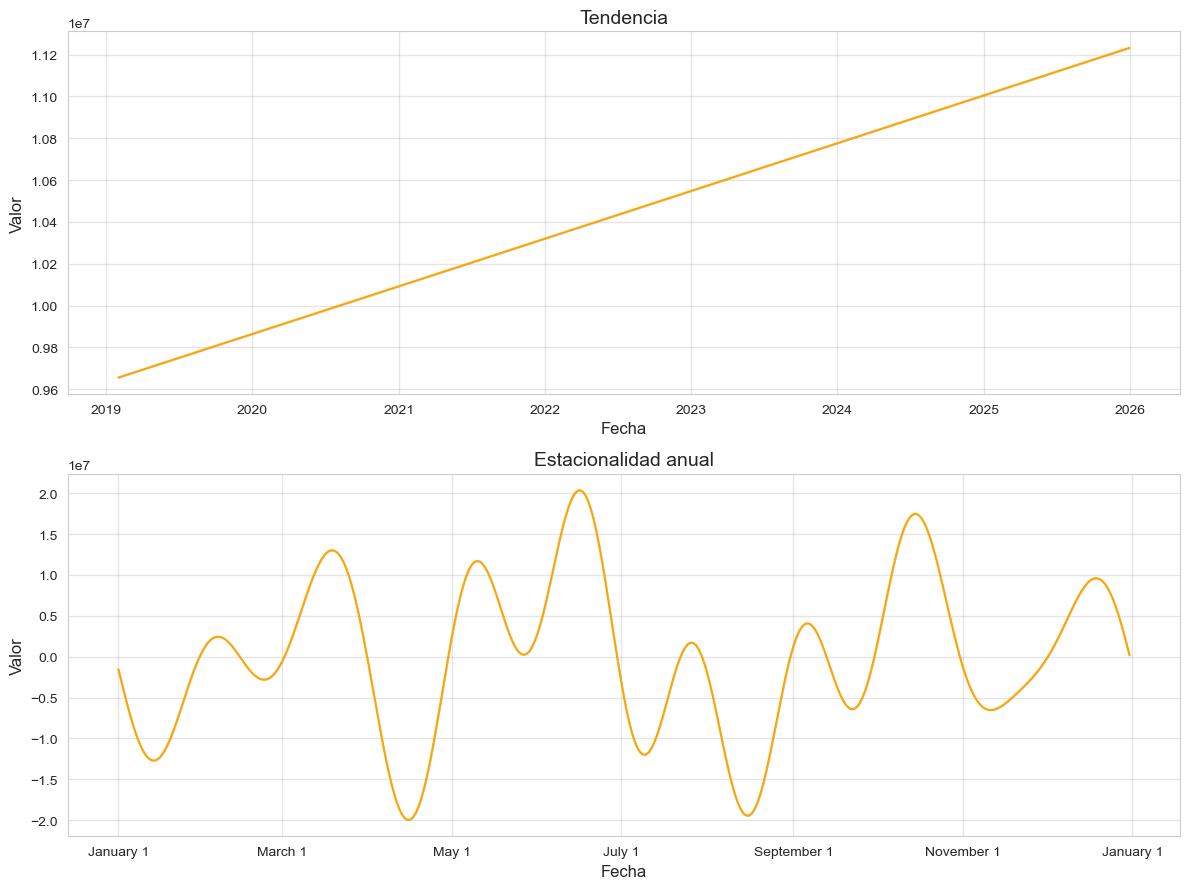

In [107]:
fig = model.plot_components(forecast, figsize=(12, 9))

# Personalizar el color de las líneas en cada gráfico
for ax in fig.axes:
    for line in ax.get_lines():
        line.set_color('orange')  

# Agregar títulos en español
titulos = ["Tendencia", "Estacionalidad anual", "Estacionalidad semanal"]  
for ax, titulo in zip(fig.axes, titulos):
    ax.set_title(titulo, fontsize=14)
    ax.set_xlabel("Fecha", fontsize=12)
    ax.set_ylabel("Valor", fontsize=12)

plt.tight_layout()
plt.show()

# Analisis de Inventario

In [218]:
df1 = pd.read_csv("Inventario_historico.csv")

In [220]:
df1.head()

,fecha,producto,margen,ventas_totales
0,2020-01-01,Grifería de Ducha y Tina,0.249816,10860
1,2020-01-01,Lavamanos,0.173374,86820
2,2020-01-01,Grifería de Lavamanos,0.162407,92386
3,2020-01-01,Cerámicos,0.139990,97498
4,2020-01-01,Mosaicos,0.446470,54131


In [178]:
df.info

<bound method DataFrame.info of           Fecha                 Categoria  Cantidad_Producto  Ingreso  \
0    2019-01-01                  mosaicos                 29   603055   
1    2019-01-02         griferia de bidet                 21   356244   
2    2019-01-03       barras de seguridad                 19   214035   
3    2019-01-04                     tinas                 11   103686   
4    2019-01-05  griferia de ducha y tina                  8   593048   
...         ...                       ...                ...      ...   
2187 2024-12-27   accesibilidad universal                  3    37362   
2188 2024-12-28  griferia de ducha y tina                 14   243180   
2189 2024-12-29                  mosaicos                  7  1028475   
2190 2024-12-30   accesibilidad universal                  4   385884   
2191 2024-12-31       pisos fotolaminados                 29   596240   

      Precio_Unitario   Año  Mes  Costo_Estimado    Margen  
0                6177  2019   

In [8]:
import matplotlib.ticker as mticker

In [10]:
import matplotlib.dates as mdates

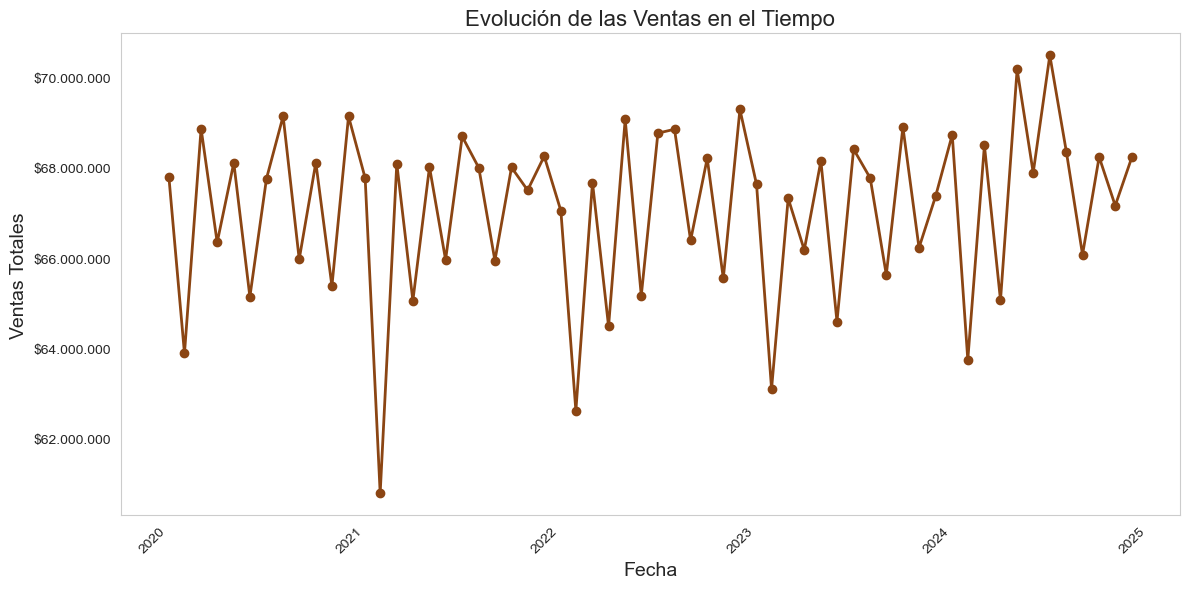

In [222]:
# Asegurar que 'fecha' es de tipo datetime
df1['fecha'] = pd.to_datetime(df1['fecha'])

# Agrupar por mes y calcular las ventas totales
df1.set_index('fecha', inplace=True)
ventas_mensuales = df1.resample('M')['ventas_totales'].sum()

# Crear el gráfico
plt.figure(figsize=(12, 6))
plt.plot(ventas_mensuales.index, ventas_mensuales, marker='o', color='saddlebrown', linestyle='-', linewidth=2)

# Formatear el eje Y en pesos chilenos
def formatear_miles(valor, _):
    return f"${valor:,.0f}".replace(",", ".")

plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(formatear_miles))

# Títulos y etiquetas
plt.title("Evolución de las Ventas en el Tiempo", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Ventas Totales", fontsize=14)

# Mejorar la visualización de las fechas en el eje X
plt.xticks(rotation=45)

# Agregar cuadrícula
plt.grid()

# Mostrar el gráfico
plt.tight_layout()
plt.show()


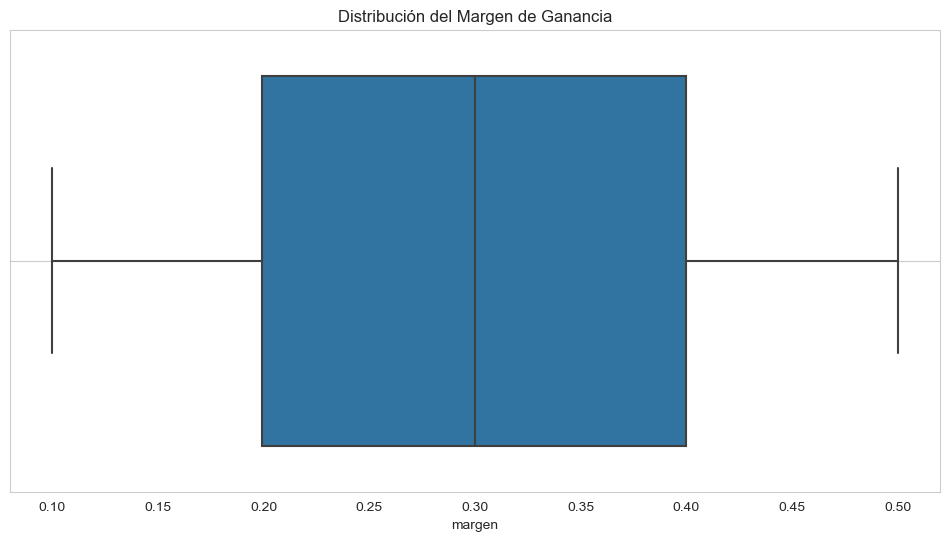

In [224]:
# Análisis de rentabilidad
plt.figure(figsize=(12, 6))
sns.boxplot(data=df1, x='margen')
plt.title("Distribución del Margen de Ganancia")
plt.grid()
plt.show()

In [134]:
# Segementacion de productos

productos_top = df1.groupby('producto')[['ventas_totales', 'margen']].mean()
productos_top = productos_top.sort_values(by='ventas_totales', ascending=False).head(10)
print(productos_top)

                                 ventas_totales    margen
producto                                                 
Organizadores                      56020.015873  0.301285
Toalleros                          55891.425835  0.301676
Pisos Fotolaminados                55810.209633  0.302098
Modulos                            55741.379310  0.302407
Espejos                            55697.602627  0.297177
Muebles de Baño                    55555.342091  0.302994
Lavaplatos                         55447.337712  0.297652
Escobillas                         55427.706076  0.300648
Pisos Vinílicos                    55405.455391  0.297611
Complementos de Pisos Orgánicos    55368.807882  0.297982


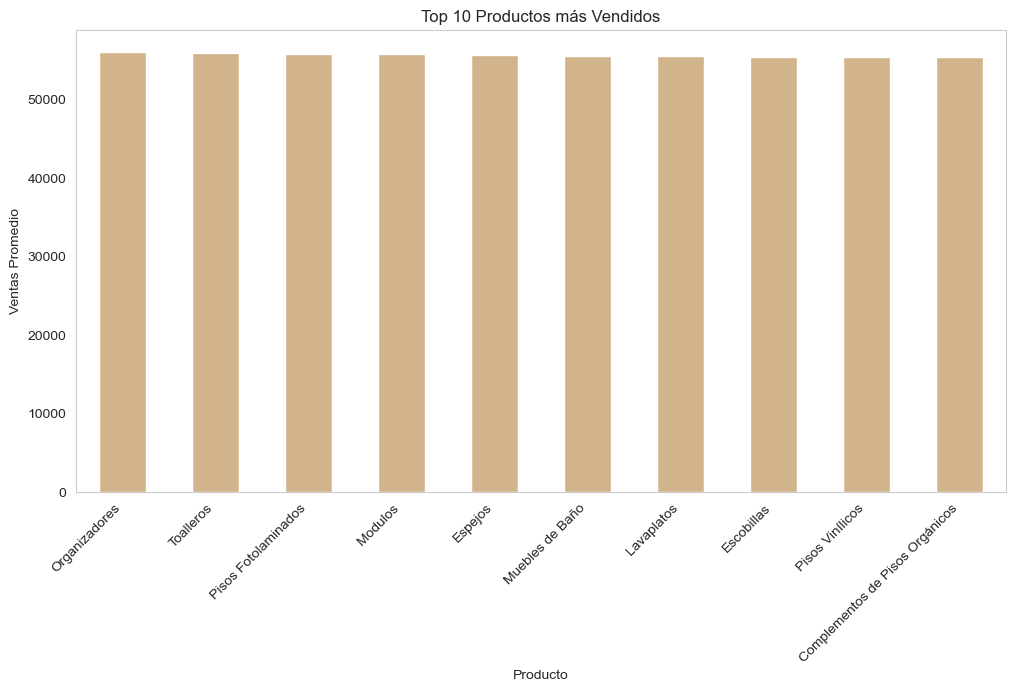

In [136]:
plt.figure(figsize=(12, 6))
productos_top['ventas_totales'].plot(kind='bar', color='tan')
plt.title("Top 10 Productos más Vendidos")
plt.xlabel("Producto")
plt.ylabel("Ventas Promedio")
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.show()

In [256]:
# Predicción de ventas con Holt-Winters

ventas_ts = df1.groupby('fecha')['ventas_totales'].sum()
modelo = ExponentialSmoothing(ventas_ts, seasonal='add', seasonal_periods=12).fit()
predicciones = modelo.forecast(steps=12)

C:\Users\Axel\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Axel\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [252]:
ventas_ts.head()

fecha
2020-01-01    2362180
2020-01-02    2179702
2020-01-03    1894306
2020-01-04    2365540
2020-01-05    2311596
Name: ventas_totales, dtype: int64

In [226]:
# Agrupar por fecha y producto y calcular las ventas totales
historico_ventas = df1.groupby(['fecha', 'producto'])[['ventas_totales']].sum().reset_index()

# Mostrar el histórico de ventas
print(historico_ventas)

# Si deseas ver el histórico de un producto específico, puedes filtrar
producto_especifico = 'Nombre del Producto'  # Reemplaza con el nombre del producto que deseas
historico_producto = historico_ventas[historico_ventas['producto'] == producto_especifico]

# Mostrar el histórico de ventas del producto específico
print(historico_producto)

           fecha                    producto  ventas_totales
0     2020-01-01     Accesibilidad Universal           96807
1     2020-01-01  Accesorios Institucionales           90077
2     2020-01-01         Barras de Seguridad           82409
3     2020-01-01                       Bidet           77121
4     2020-01-01                   Cerámicos           97498
...          ...                         ...             ...
73075 2024-12-31                       Tinas           70386
73076 2024-12-31                   Toalleros           22688
73077 2024-12-31                   Urinarios           85278
73078 2024-12-31                          WC           15876
73079 2024-12-31                 Wall Panels           10582

[73080 rows x 3 columns]
Empty DataFrame
Columns: [fecha, producto, ventas_totales]
Index: []


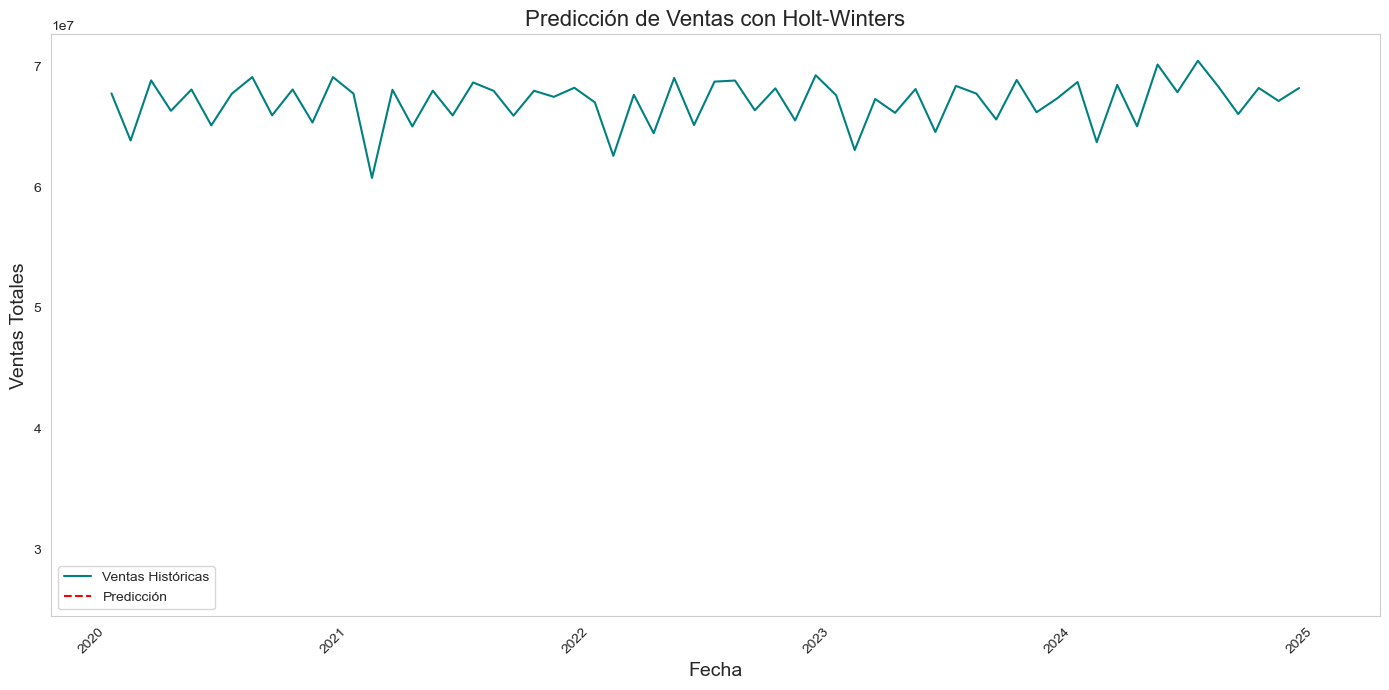

In [254]:
ventas_ts.index = pd.to_datetime(ventas_ts.index)
predicciones.index = pd.to_datetime(predicciones.index)

# Agrupar por mes y calcular las ventas totales
ventas_mensuales = ventas_ts.resample('M').sum()
predicciones_mensuales = predicciones.resample('M').sum()

# Crear el gráfico
plt.figure(figsize=(14, 7))  # Aumentar el tamaño de la figura
plt.plot(ventas_mensuales.index, ventas_mensuales, label='Ventas Históricas', color='teal')
plt.plot(predicciones_mensuales.index, predicciones_mensuales, label='Predicción', linestyle='dashed', color='red')

# Títulos y etiquetas
plt.title("Predicción de Ventas con Holt-Winters", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Ventas Totales", fontsize=14)

# Mejorar la visualización de las fechas en el eje X
plt.xticks(rotation=45)  # Rotar las etiquetas del eje X para que sean más legibles

# Agregar leyenda y cuadrícula
plt.legend()
plt.grid()

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()

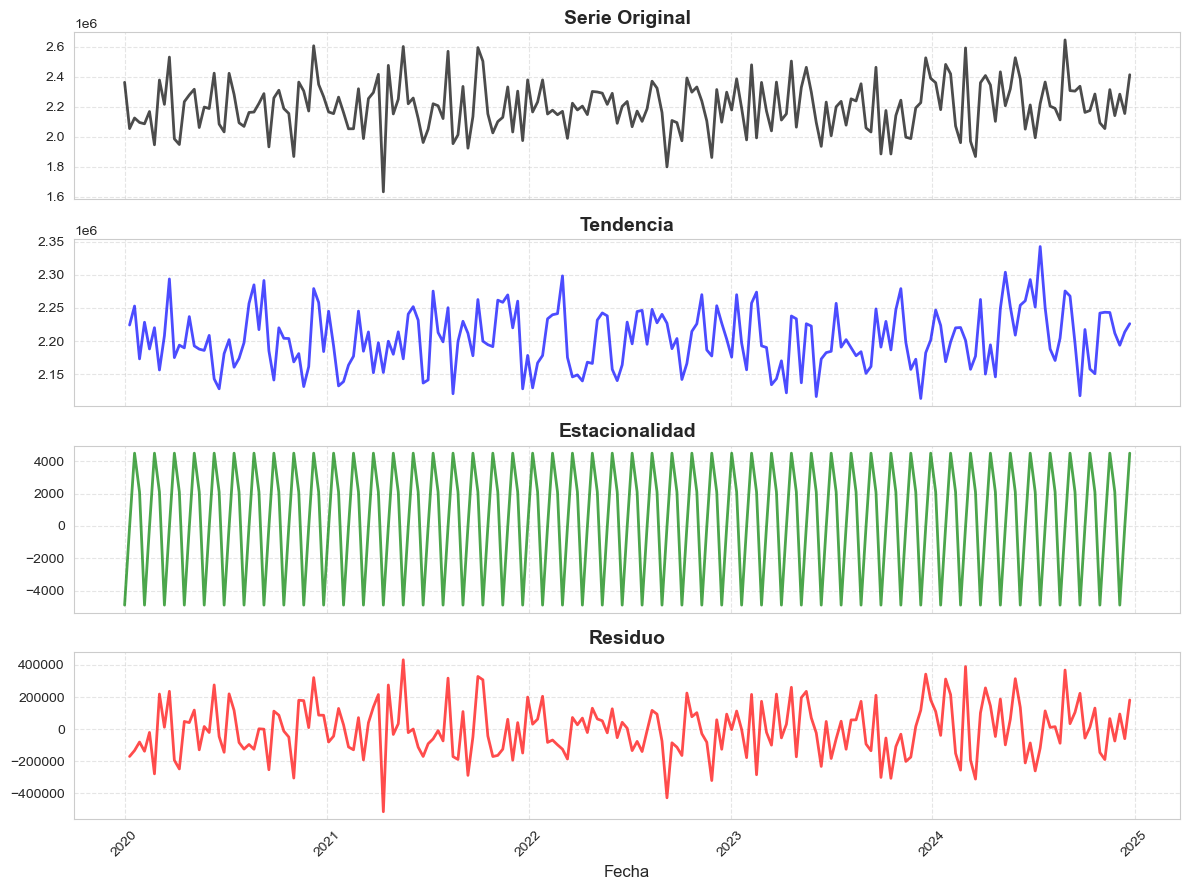

Análisis de Inventario Completo en Jupyter Notebook


In [166]:
# Descomposición estacional
decompose = seasonal_decompose(ventas_ts, model='additive', period=12)

# Reducir la cantidad de puntos para visualización
muestras = 200  # Número de puntos a graficar
step = max(1, len(ventas_ts) // muestras)  # Calcular el paso de muestreo

# Aplicar muestreo a la serie y a los componentes
ventas_ts_sampled = ventas_ts[::step]
trend_sampled = decompose.trend[::step]
seasonal_sampled = decompose.seasonal[::step]
resid_sampled = decompose.resid[::step]

# Configurar la figura
fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=True)

# Componentes de la descomposición
componentes = ["Serie Original", "Tendencia", "Estacionalidad", "Residuo"]
datos = [ventas_ts_sampled, trend_sampled, seasonal_sampled, resid_sampled]
colores = ["black", "blue", "green", "red"]

# Graficar cada componente con transparencia y líneas suaves
for ax, dato, titulo, color in zip(axes, datos, componentes, colores):
    ax.plot(dato, color=color, linewidth=2, alpha=0.7)
    ax.set_title(titulo, fontsize=14, fontweight="bold")
    ax.grid(True, linestyle="--", alpha=0.5)

# Mejorar la distribución del gráfico
plt.xlabel("Fecha", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Análisis de Inventario Completo en Jupyter Notebook")

# Analisis de clientes

In [12]:
df2 = pd.read_csv("Clientes_historico.csv")

In [14]:
df2.head()

,identificacion_cliente,fecha_compra,monto_compra
0,10211564-9,2020-01-18,97219.72
1,10211564-9,2020-01-28,97219.72
2,10211564-9,2020-01-28,97219.72
3,10211564-9,2020-01-28,97219.72
4,10211564-9,2020-02-10,97219.72


In [16]:
df2['fecha_compra'] = pd.to_datetime(df2['fecha_compra'], errors = 'coerce')

In [18]:
# Análisis de Clientes
clientes_resumen = df2.groupby("identificacion_cliente").agg(
    frecuencia=("fecha_compra", "count"),
    total_gastado=("monto_compra", "sum"),
    ultima_compra=("fecha_compra", "max")
).reset_index()

In [20]:
# Ticket promedio
ticket_promedio = df2["monto_compra"].mean()
print(ticket_promedio)

108014.14309986221


In [22]:
# Tendencias de ventas por mes
df2["año_mes"] = df2["fecha_compra"].dt.to_period("M")
ventas_mensuales = df2.groupby("año_mes")["monto_compra"].sum()

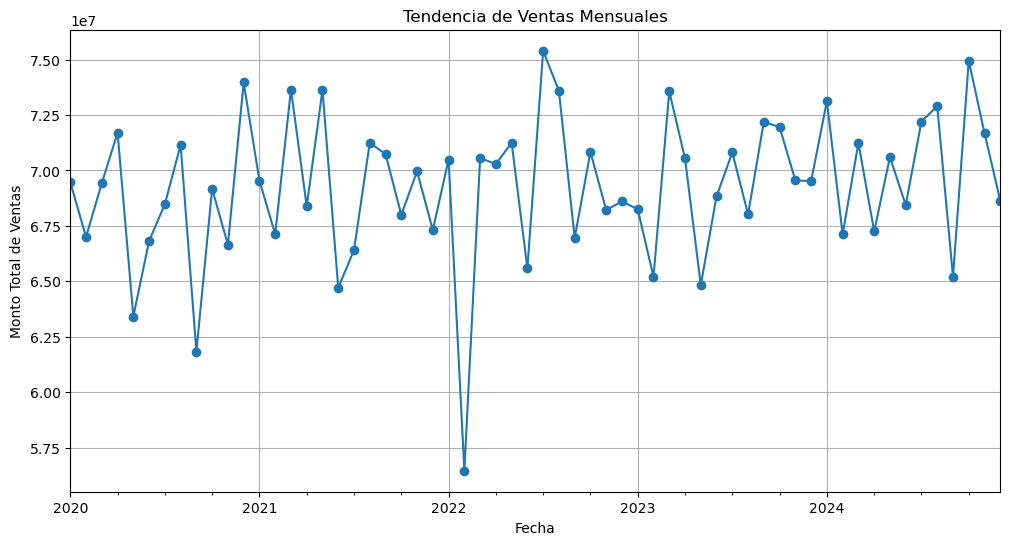

In [24]:
# Visualización de tendencias de ventas
plt.figure(figsize=(12, 6))
ventas_mensuales.plot(marker="o")
plt.title("Tendencia de Ventas Mensuales")
plt.xlabel("Fecha")
plt.ylabel("Monto Total de Ventas")
plt.grid()
plt.show()

In [26]:
# Identificación de clientes inactivos
fecha_max = df2["fecha_compra"].max()
inactivos = clientes_resumen[clientes_resumen["ultima_compra"] < fecha_max - pd.DateOffset(months=6)]
print(fecha_max)
print(inactivos)

2024-12-31 00:00:00
    identificacion_cliente  frecuencia  total_gastado ultima_compra
20              12524601-8           4      538003.04    2022-12-13
34              14646191-1          22     3612423.32    2024-05-03
88              22405791-3          12      452428.92    2024-06-25
104              3076781-8           8      888082.24    2024-03-24
119              6517871-8           2      248482.96    2023-12-01


In [28]:
# Segmentación de clientes por gasto
clientes_resumen["segmento"] = pd.qcut(clientes_resumen["total_gastado"], 4, labels=["Bajo", "Medio", "Alto", "Premium"])

In [30]:
print(clientes_resumen)

    identificacion_cliente  frecuencia  total_gastado ultima_compra segmento
0               10211564-9         394    38304569.68    2024-12-31     Alto
1               10280965-5         373    64482210.88    2024-12-28  Premium
2               10490984-4          95    11278937.70    2024-12-23    Medio
3               10775675-5         164     7882599.32    2024-12-25     Bajo
4               11046926-0         499    23425380.35    2024-12-29    Medio
..                     ...         ...            ...           ...      ...
145              9304360-3         278    43147298.58    2024-12-29  Premium
146              9617568-6         282    48677906.58    2024-12-16  Premium
147              9769754-3         266    21209991.46    2024-12-27    Medio
148              9883357-5         439    66845700.29    2024-12-28  Premium
149              9952225-2          30     1288161.00    2024-10-03     Bajo

[150 rows x 5 columns]


In [32]:
# Análisis RFM
hoy = fecha_max
clientes_resumen["recencia"] = (hoy - clientes_resumen["ultima_compra"]).dt.days
clientes_resumen["frecuencia"] = df2.groupby("identificacion_cliente")["fecha_compra"].transform("count")
clientes_resumen["monetario"] = df2.groupby("identificacion_cliente")["monto_compra"].transform("sum")

In [34]:
# Predicción de clientes que pueden abandonar
clientes_resumen["abandonado"] = clientes_resumen["ultima_compra"] < fecha_max - pd.DateOffset(months=6)
X = clientes_resumen[["recencia", "frecuencia", "monetario"]]
y = clientes_resumen["abandonado"].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00         1

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



C:\Users\Axel\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


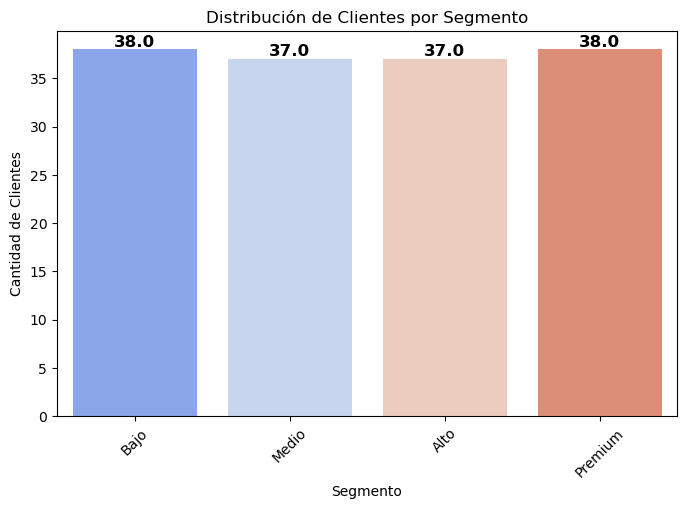

In [44]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x="segmento", data=clientes_resumen, palette="coolwarm")

# Agregar etiquetas con el número de clientes por segmento
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title("Distribución de Clientes por Segmento")
plt.xlabel("Segmento")
plt.ylabel("Cantidad de Clientes")
plt.xticks(rotation=45)  # Rotar etiquetas si hay muchos segmentos
plt.show()

C:\Users\Axel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


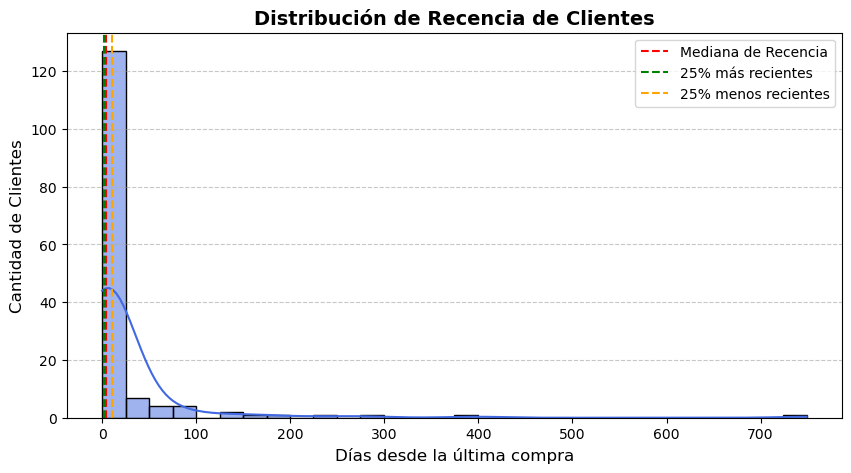

In [46]:
# Configuración del gráfico
plt.figure(figsize=(10, 5))
ax = sns.histplot(clientes_resumen["recencia"], bins=30, kde=True, color="royalblue")

# Agregar líneas de referencia para identificar grupos de clientes
plt.axvline(clientes_resumen["recencia"].median(), color="red", linestyle="dashed", label="Mediana de Recencia")
plt.axvline(clientes_resumen["recencia"].quantile(0.25), color="green", linestyle="dashed", label="25% más recientes")
plt.axvline(clientes_resumen["recencia"].quantile(0.75), color="orange", linestyle="dashed", label="25% menos recientes")

# Título y etiquetas
plt.title("Distribución de Recencia de Clientes", fontsize=14, fontweight="bold")
plt.xlabel("Días desde la última compra", fontsize=12)
plt.ylabel("Cantidad de Clientes", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle="--", alpha=0.7)  # Agregar cuadrícula en el eje Y

plt.show()

In [99]:
# Mostrar segmentación y análisis RFM
clientes_resumen.head(50)


,identificacion_cliente,frecuencia,total_gastado,ultima_compra,segmento,recencia,monetario,abandonado
0,10211564-9,394,38304569.68,2024-12-31,Alto,0,38304569.68,False
1,10280965-5,394,64482210.88,2024-12-28,Premium,3,38304569.68,False
2,10490984-4,394,11278937.70,2024-12-23,Medio,8,38304569.68,False
3,10775675-5,394,7882599.32,2024-12-25,Bajo,6,38304569.68,False
4,11046926-0,394,23425380.35,2024-12-29,Medio,2,38304569.68,False
5,11159724-9,394,77409475.20,2024-12-31,Premium,0,38304569.68,False
6,11342365-2,394,38285912.00,2024-12-30,Alto,1,38304569.68,False
7,11406400-5,394,57284550.00,2024-12-30,Premium,1,38304569.68,False
8,11503324-2,394,64919919.78,2024-12-17,Premium,14,38304569.68,False
9,11527795-0,394,24605640.60,2024-12-27,Alto,4,38304569.68,False


In [105]:
clientes_resumen.describe()

,frecuencia,total_gastado,ultima_compra,recencia,monetario
count,150.0,1.500000e+02,150,150.000000,1.500000e+02
mean,394.0,2.769699e+07,2024-12-05 23:50:24,25.006667,3.830457e+07
min,394.0,2.484830e+05,2022-12-13 00:00:00,0.000000,3.830457e+07
25%,394.0,8.054934e+06,2024-12-20 00:00:00,2.000000,3.830457e+07
50%,394.0,2.365191e+07,2024-12-26 12:00:00,4.500000,3.830457e+07
75%,394.0,4.147187e+07,2024-12-29 00:00:00,11.000000,3.830457e+07
max,394.0,9.674818e+07,2024-12-31 00:00:00,749.000000,3.830457e+07
std,0.0,2.252423e+07,NaN,78.648696,2.242662e-08


# Analisis de logistica


In [62]:
df3 = pd.read_csv("logistica_historico.csv")

In [64]:
df3.head()

,Fecha,Costo total,Peaje,Región,Ciudad,Distancia en KM
0,2020-01-01,149696,No,Tarapacá,Alto Hospicio,15
1,2020-01-02,83474,No,La Araucanía,Villarrica,85
2,2020-01-03,126022,Sí,La Araucanía,Temuco,300
3,2020-01-04,76780,Sí,Magallanes,Punta Arenas,400
4,2020-01-05,123781,No,La Araucanía,Temuco,300


In [66]:
df3.info

<bound method DataFrame.info of            Fecha  Costo total Peaje        Región         Ciudad  \
0     2020-01-01       149696    No      Tarapacá  Alto Hospicio   
1     2020-01-02        83474    No  La Araucanía     Villarrica   
2     2020-01-03       126022    Sí  La Araucanía         Temuco   
3     2020-01-04        76780    Sí    Magallanes   Punta Arenas   
4     2020-01-05       123781    No  La Araucanía         Temuco   
...          ...          ...   ...           ...            ...   
1822  2024-12-27        56625    Sí    Valparaíso   Viña del Mar   
1823  2024-12-28       116323    No  La Araucanía     Villarrica   
1824  2024-12-29        58915    Sí      Los Ríos       Valdivia   
1825  2024-12-30       115136    No     Los Lagos         Castro   
1826  2024-12-31        72925    No         Aysén   Puerto Aysén   

      Distancia en KM  
0                  15  
1                  85  
2                 300  
3                 400  
4                 300  
...    

In [68]:
# Convertir Fecha a tipo datetime
df3["Fecha"] = pd.to_datetime(df3["Fecha"])

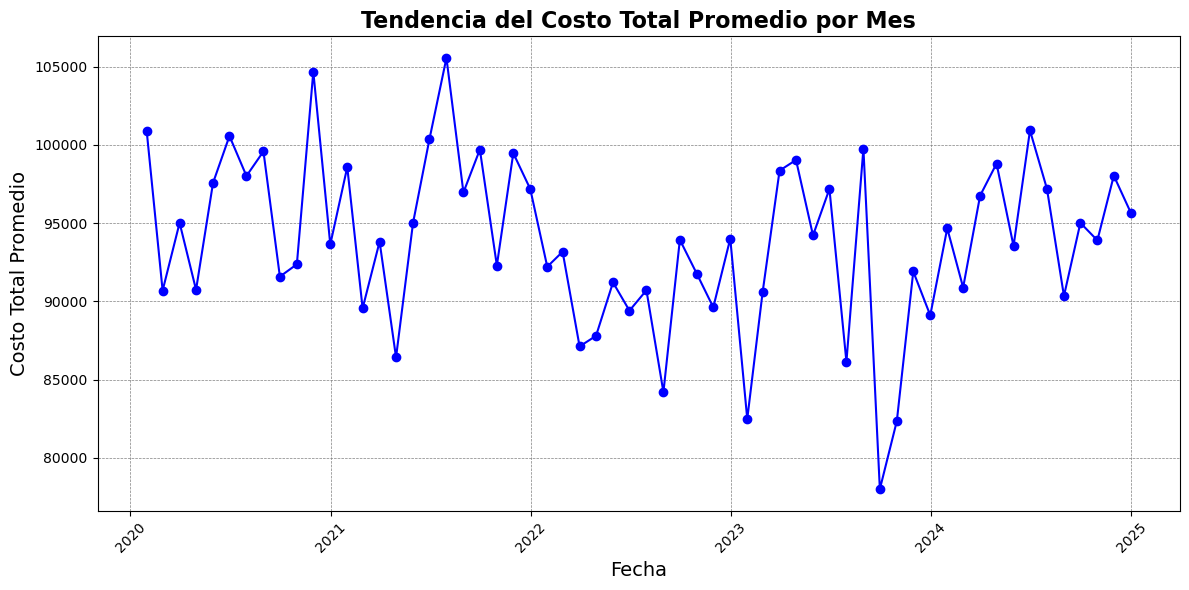

In [70]:
# Agrupar por mes y calcular el costo total promedio
df3_resumido = df3.resample('M', on='Fecha')['Costo total'].mean().reset_index()

# Crear una figura con un tamaño específico
plt.figure(figsize=(12, 6))

# Graficar los datos resumidos
plt.plot(df3_resumido['Fecha'], df3_resumido['Costo total'], color='blue', marker='o', linestyle='-')

# Título del gráfico
plt.title("Tendencia del Costo Total Promedio por Mes", fontsize=16, fontweight='bold')

# Etiqueta del eje Y
plt.ylabel("Costo Total Promedio", fontsize=14)

# Etiqueta del eje X
plt.xlabel("Fecha", fontsize=14)

# Configuración de la cuadrícula
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Mejorar la visualización de las fechas en el eje X
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

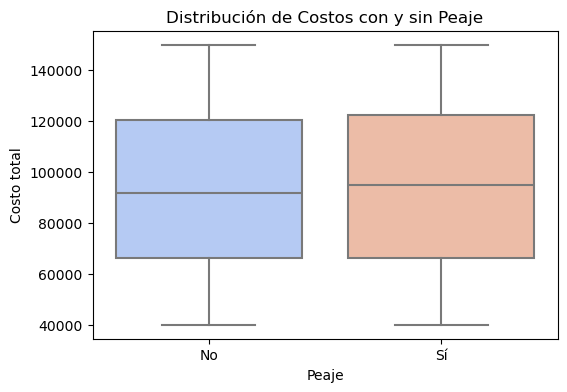

In [72]:
# Análisis 2: Comparación de costos con y sin peaje
plt.figure(figsize=(6,4))
sns.boxplot(x=df3["Peaje"], y=df3["Costo total"], palette="coolwarm")
plt.title("Distribución de Costos con y sin Peaje")
plt.show()


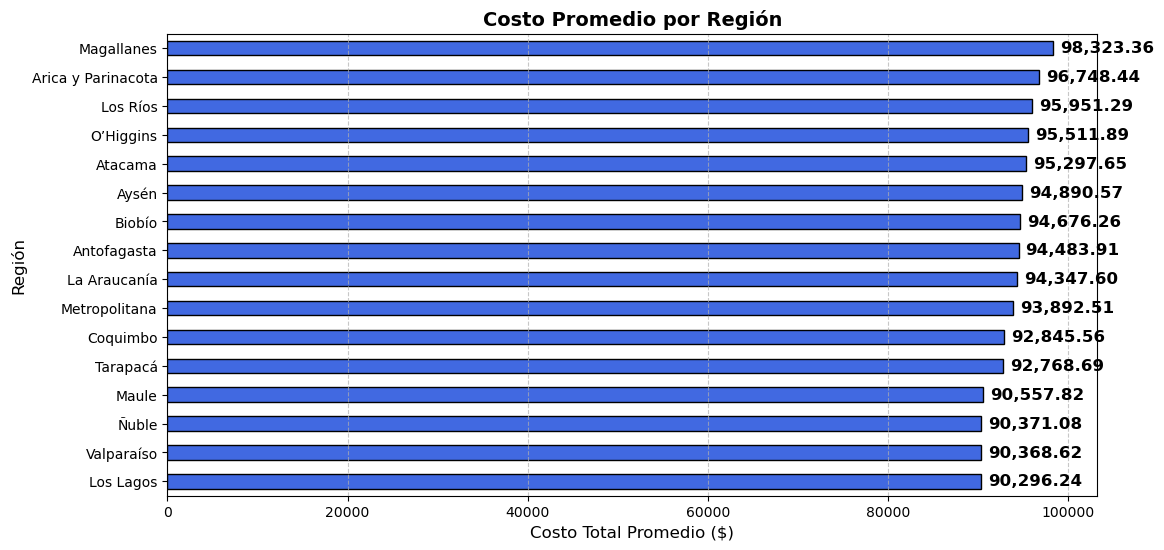

In [78]:
# Configuración del gráfico
plt.figure(figsize=(12, 6))
ax = df3.groupby("Región")["Costo total"].mean().sort_values().plot(kind="barh", color="royalblue", edgecolor="black")

# Agregar etiquetas con los valores en cada barra
for p in ax.patches:
    ax.annotate(f"{p.get_width():,.2f}", (p.get_width(), p.get_y() + p.get_height() / 2),
                ha="left", va="center", fontsize=12, fontweight="bold", color="black", xytext=(5, 0), textcoords="offset points")

# Títulos y etiquetas
plt.title("Costo Promedio por Región", fontsize=14, fontweight="bold")
plt.xlabel("Costo Total Promedio ($)", fontsize=12)
plt.ylabel("Región", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)  # Agregar una cuadrícula para mejorar la lectura

# Mostrar el gráfico
plt.show()

C:\Users\Axel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


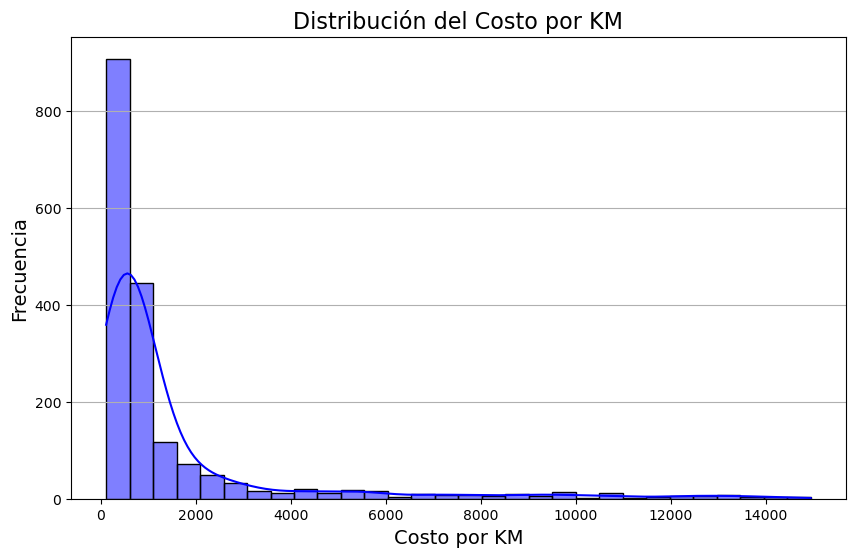

count     1827.000000
mean      1492.559836
std       2455.819310
min        110.100000
25%        390.397727
50%        609.016667
75%       1136.125000
max      14941.100000
Name: Costo por KM, dtype: float64


In [80]:
# Filtrar filas donde la distancia es mayor que 0
df3 = df3[df3["Distancia en KM"] > 0]  
df3["Costo por KM"] = df3["Costo total"] / df3["Distancia en KM"]

# Crear un histograma
plt.figure(figsize=(10, 6))
sns.histplot(df3["Costo por KM"], bins=30, kde=True, color='blue', edgecolor='black')
plt.title("Distribución del Costo por KM", fontsize=16)
plt.xlabel("Costo por KM", fontsize=14)
plt.ylabel("Frecuencia", fontsize=14)
plt.grid(axis='y')

# Mostrar el gráfico
plt.show()

# Mostrar estadísticas descriptivas
print(df3["Costo por KM"].describe())

C:\Users\Axel\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


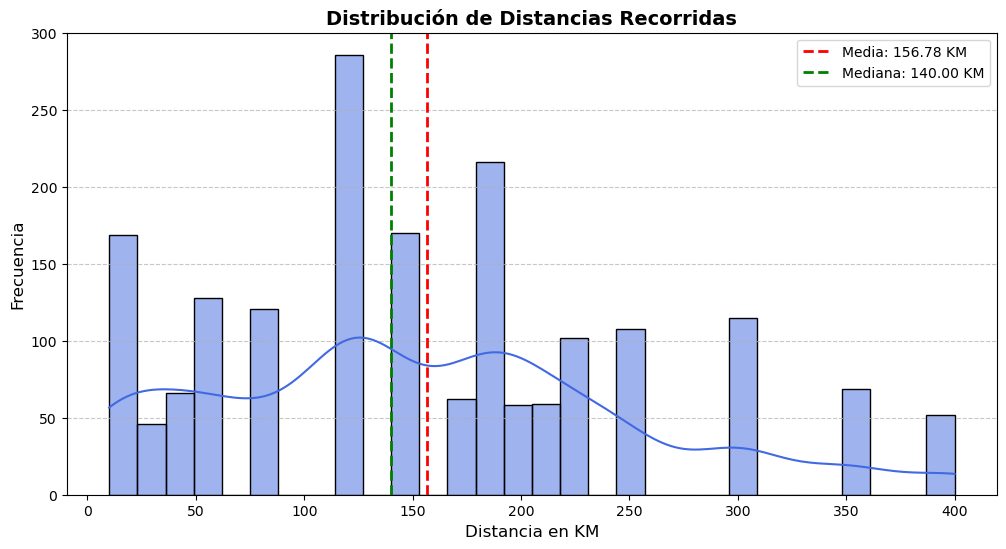

In [82]:
# Análisis 5: Distribución de distancias recorridas
# Configuración del gráfico
plt.figure(figsize=(12, 6))
ax = sns.histplot(df3["Distancia en KM"], bins=30, kde=True, color="royalblue", edgecolor="black")

# Agregar líneas de referencia para estadísticas clave
plt.axvline(df3["Distancia en KM"].mean(), color="red", linestyle="dashed", linewidth=2, label=f"Media: {df3['Distancia en KM'].mean():,.2f} KM")
plt.axvline(df3["Distancia en KM"].median(), color="green", linestyle="dashed", linewidth=2, label=f"Mediana: {df3['Distancia en KM'].median():,.2f} KM")

# Títulos y etiquetas
plt.title("Distribución de Distancias Recorridas", fontsize=14, fontweight="bold")
plt.xlabel("Distancia en KM", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Agregar cuadrícula en el eje Y para mejor lectura

# Mostrar el gráfico
plt.show()

In [84]:
df3.head()

,Fecha,Costo total,Peaje,Región,Ciudad,Distancia en KM,Costo por KM
0,2020-01-01,149696,No,Tarapacá,Alto Hospicio,15,9979.733333
1,2020-01-02,83474,No,La Araucanía,Villarrica,85,982.047059
2,2020-01-03,126022,Sí,La Araucanía,Temuco,300,420.073333
3,2020-01-04,76780,Sí,Magallanes,Punta Arenas,400,191.950000
4,2020-01-05,123781,No,La Araucanía,Temuco,300,412.603333
